In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet 
from nltk.corpus import wordnet 
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import spacy

from typing import List
from pprint import pprint


import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim

import tqdm

%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# EDA
### PREPROCESSING

In [12]:
lotr_data = pd.read_csv("lotr_scripts.csv")
lotr_data.head()

,Unnamed: 0,char,dialog,movie
0,0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King
1,1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King
2,2,DEAGOL,Arrghh!,The Return of the King
3,3,SMEAGOL,Deagol!,The Return of the King
4,4,SMEAGOL,Deagol!,The Return of the King


In [13]:
lotr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2390 non-null   int64 
 1   char        2390 non-null   object
 2   dialog      2389 non-null   object
 3   movie       2390 non-null   object
dtypes: int64(1), object(3)
memory usage: 74.8+ KB


In [14]:
# Spotting inconcistencies with naming
lotr_data.char.unique()

array(['DEAGOL', 'SMEAGOL', '(GOLLUM', 'FRODO', 'MERRY', 'GIMLI',
       'GOLLUM', 'SAM', 'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE',
       'BILBO', 'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIL', 'ELROND',
       'GRIMA', 'FRODO VOICE OVER', 'WITCH KING', 'EOWYN', 'FARAMIR',
       'ORC', '\xa0GANDALF', 'SOLDIERS ON GATE', 'GOTHMOG', 'GENERAL',
       'CAPTAIN', 'SOLDIER', 'MOUTH OF SAURON', 'EOMER', 'ARMY', 'BOSON',
       'MERCENARY', 'EOWYN/MERRY', 'DENETHOR', 'ROHIRRIM',
       'GALADRIEL VOICEOVER', 'LEGOLAS', 'GALADRIEL', 'KING OF THE DEAD',
       'GRIMBOLD', 'IROLAS', 'ORCS', 'GAMLING', 'MADRIL', 'DAMROD',
       'SOLDIERS', 'SOLDIERS IN MINAS TIRITH', 'GANDALF VOICEOVER',
       'SOLDIER 1', 'SOLDIER 2', 'WOMAN', 'HALDIR', 'SAM VOICEOVER',
       'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'ELROND VOICEOVER',
       'ARWEN VOICEOVER', 'ARAGORN ', 'HAMA', 'SHARKU', 'PEOPLE', 'LADY',
       'FREDA', 'MORWEN', 'EYE OF SAURON', 'ROHAN STABLEMAN', 'GORBAG',
       'ARGORN', 'GA

In [15]:
flaws = list(["(GOLLUM", "GALADRIL", "FRODO VOICE OVER", "\xa0GANDALF", "MOUTH OF SAURON", "GALADRIEL VOICEOVER", "GANDALF VOICEOVER", 
         "SAM VOICEOVER", "ELROND VOICEOVER", "ARWEN VOICEOVER", "ARAGORN ", "ARGORN", "GANDALF VOICE OVER", "SARUMAN VOICE OVER", 
         "SARUMAN VOICE OVER ", "URUK-HAI" "FRODO ", "GALADRIEL VOICE-OVER", "SAURON VOICE", "SAM ", "FRODO VOICE", 
         "GALADRIEL VOICE OVER", "SARUMAN VOICEOVER", "BILBO VOICEOVER", "GATEKEEPR", "GAN DALF"])

correct = list(["GOLLUM", "GALADRIEL", "FRODO", "GANDALF","SAURON", "GALADRIEL", "GANDALF", "SAM", "ELROND", "ARWEN", "ARAGORN", "ARAGORN", 
                "GANDALF", "SARUMAN", "SARUMAN", "URUK HAI", "FRODO", "GALADRIEL", "SAURON", "SAM", "FRODO", "GALADRIEL", "SARUMAN", 
                "BILBO", "GATEKEEPER", "GANDALF"])

for i in range(len(flaws)):
    lotr_data.loc[lotr_data["char"] == flaws[i], "char"] = correct[i]
lotr_data.char.unique()


array(['DEAGOL', 'SMEAGOL', 'GOLLUM', 'FRODO', 'MERRY', 'GIMLI', 'SAM',
       'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE', 'BILBO',
       'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIEL', 'ELROND', 'GRIMA',
       'WITCH KING', 'EOWYN', 'FARAMIR', 'ORC', 'SOLDIERS ON GATE',
       'GOTHMOG', 'GENERAL', 'CAPTAIN', 'SOLDIER', 'SAURON', 'EOMER',
       'ARMY', 'BOSON', 'MERCENARY', 'EOWYN/MERRY', 'DENETHOR',
       'ROHIRRIM', 'LEGOLAS', 'KING OF THE DEAD', 'GRIMBOLD', 'IROLAS',
       'ORCS', 'GAMLING', 'MADRIL', 'DAMROD', 'SOLDIERS',
       'SOLDIERS IN MINAS TIRITH', 'SOLDIER 1', 'SOLDIER 2', 'WOMAN',
       'HALDIR', 'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'HAMA', 'SHARKU',
       'PEOPLE', 'LADY', 'FREDA', 'MORWEN', 'EYE OF SAURON',
       'ROHAN STABLEMAN', 'GORBAG', 'BOROMIR ', 'UGLUK', 'SHAGRAT',
       'FRODO ', 'URUK-HAI', 'SNAGA', 'GRISHNAKH', 'MERRY and PIPPIN',
       'WILDMAN', 'STRIDER', 'EOTHAIN', 'ROHAN HORSEMAN', 'FARMER MAGGOT',
       'WHITE WIZARD', 'MERRY AND P

In [16]:
lotr_data['dialog'] = lotr_data['dialog'].fillna('')
lotr_data = lotr_data.drop(["Unnamed: 0", "movie"], axis=1)
lotr_data.head()

,char,dialog
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag..."
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!"
2,DEAGOL,Arrghh!
3,SMEAGOL,Deagol!
4,SMEAGOL,Deagol!


### Initial EDA

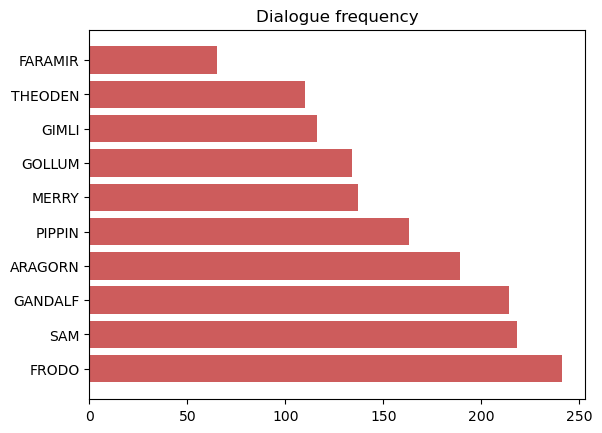

In [17]:
# Plotting dialouge frequnecy
char_freq = lotr_data.groupby("char").size().reset_index(name="freq")
char_freq = char_freq.sort_values(by="freq",ascending=False)
plt.barh(char_freq.char[:10], char_freq.freq[:10], color="indianred")
plt.title("Dialogue frequency")
plt.show()


### SIMPLE FEATURE ENGENERING

In [18]:
# Adding simple but perhaps effective features
lotr_data["word_len"] = lotr_data.dialog.apply(lambda x: len(x.split()))
lotr_data["character_len"] = lotr_data.dialog.apply(lambda x: len(x))

# Stopword counter
stopwords_set = set(stopwords.words("english"))
lotr_data["stopword_count"] = lotr_data.dialog.apply(lambda x: sum(1 for word in x.split() if word.lower() in stopwords_set))

# frequency of word classes
nlp = spacy.load("en_core_web_sm")

def count_verbs(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "VERB")

def count_adjectives(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "ADJ")

def count_proper_noun(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "PROPN")

def unique_words(text):
    return len(set(text.split()))

lotr_data['verb_count'] = lotr_data['dialog'].apply(count_verbs)
lotr_data['adj_count'] = lotr_data['dialog'].apply(count_adjectives)
lotr_data['propn_count'] = lotr_data['dialog'].apply(count_proper_noun)
lotr_data['uinque_words'] = lotr_data['dialog'].apply(unique_words)

# Ideeas for more #################
# avg. word length
# unique word ratio


lotr_data.head()

,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",12,62,1,2,0,3,10
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",12,46,2,5,0,0,7
2,DEAGOL,Arrghh!,1,8,0,1,0,0,1
3,SMEAGOL,Deagol!,1,9,0,0,0,0,1
4,SMEAGOL,Deagol!,1,9,0,0,0,0,1


C:\Users\marcu\AppData\Local\Temp\ipykernel_53876\4054842772.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


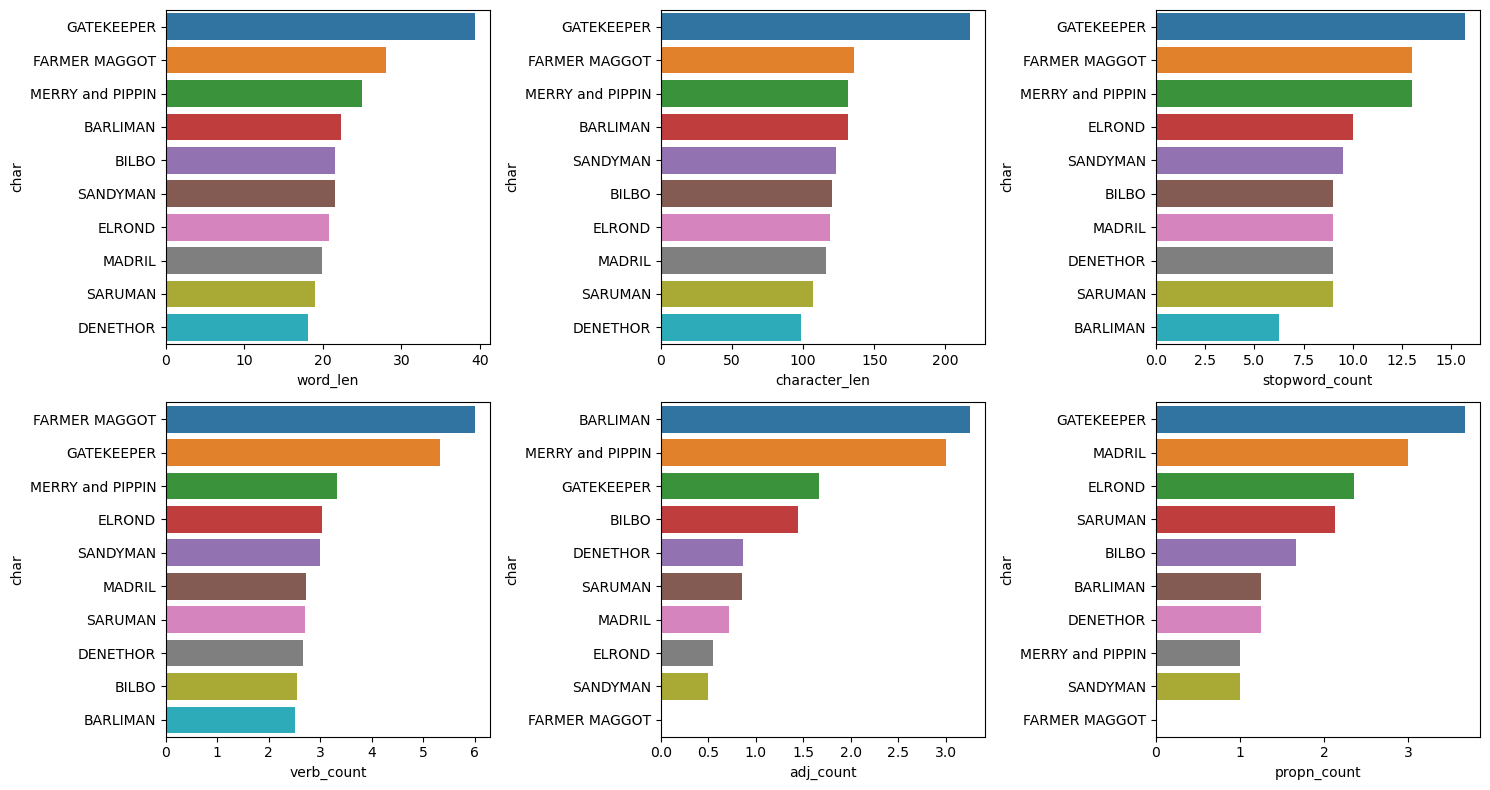

In [19]:
# Plotting dialouge frequnecy
char_var = lotr_data.groupby("char")[["word_len", "character_len", "stopword_count", "verb_count", "adj_count", "propn_count"]].mean().reset_index()
#char_var = char_var.sort_values(by="freq",ascending=False)

plt.figure(figsize = (15, 8))
plt.tight_layout()
plt.subplot(2, 3, 1)
char_var = char_var.sort_values(by="word_len", ascending=False)[:10]
sns.barplot(x=char_var.word_len, y=char_var.char)
plt.subplot(2, 3, 2)
char_var = char_var.sort_values(by="character_len", ascending=False)[:10]
sns.barplot(x=char_var.character_len, y=char_var.char)
plt.subplot(2, 3, 3)
char_var = char_var.sort_values(by="stopword_count", ascending=False)[:10]
sns.barplot(x=char_var.stopword_count, y=char_var.char)
plt.subplot(2, 3, 4)
char_var = char_var.sort_values(by="verb_count", ascending=False)[:10]
sns.barplot(x=char_var.verb_count, y=char_var.char)
plt.subplot(2, 3, 5)
char_var = char_var.sort_values(by="adj_count", ascending=False)[:10]
sns.barplot(x=char_var.adj_count, y=char_var.char)
plt.subplot(2, 3, 6)
char_var = char_var.sort_values(by="propn_count", ascending=False)[:10]
sns.barplot(x=char_var.propn_count, y=char_var.char)
plt.tight_layout()
plt.show()


### SENTIMENT ANALYSIS

In [20]:
# Dialog sentiment

def word_sentiment_score(word: str) -> float:
    synsets = list(sentiwordnet.senti_synsets(word))
    if synsets:
        sentiment = synsets[0]
        return sentiment.pos_score() - sentiment.neg_score()
    else:
        return 0.0  

def sentence_sentiment(sentence):
    sent = nlp(sentence)
    sent_sentiment = sum(word_sentiment_score(token.text) for token in sent)
    return sent_sentiment

lotr_data["dialog_sentiment"] = lotr_data['dialog'].apply(sentence_sentiment)
lotr_data

,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",12,62,1,2,0,3,10,0.250
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",12,46,2,5,0,0,7,0.000
2,DEAGOL,Arrghh!,1,8,0,1,0,0,1,0.000
3,SMEAGOL,Deagol!,1,9,0,0,0,0,1,0.000
4,SMEAGOL,Deagol!,1,9,0,0,0,0,1,0.000
...,...,...,...,...,...,...,...,...,...,...
2385,PIPPIN,Merry!,1,7,0,0,0,1,1,0.625
2386,ARAGORN,Merry!,1,7,0,0,0,1,1,0.625
2387,MERRY,He's always followed me everywhere I went sinc...,40,211,19,5,1,2,35,0.000
2388,ARAGORN,One thing I've learnt about Hobbits: They are ...,12,65,5,1,1,1,12,0.000


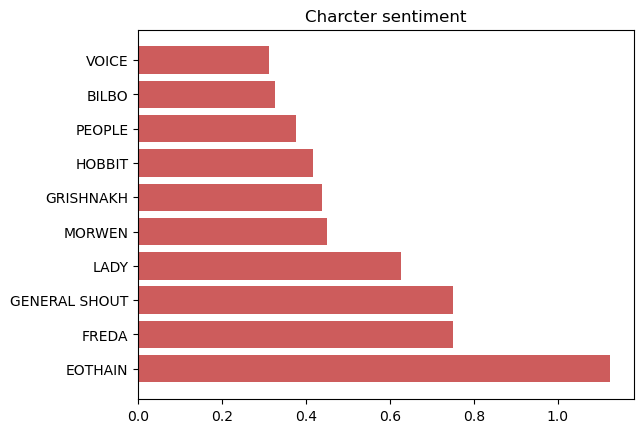

In [21]:
# Plotting dialouge frequnecy
char_sent = lotr_data.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
plt.barh(char_sent.char[:10], char_sent.dialog_sentiment[:10], color="indianred")
plt.title("Charcter sentiment")
plt.show()

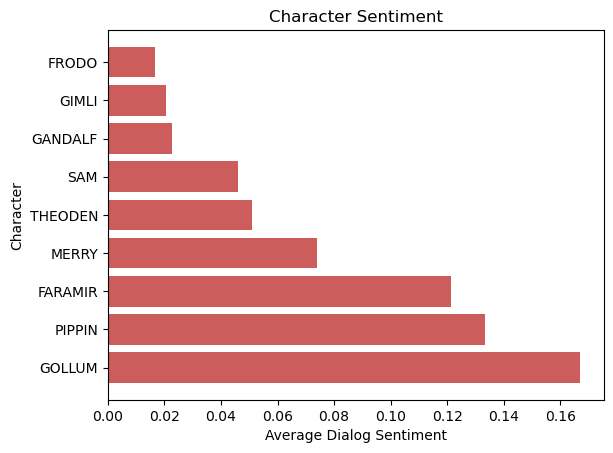

In [22]:
imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR"]
# Plotting dialouge frequnecy
char_sent = lotr_data.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
char_sent_filtered = char_sent[char_sent['char'].isin(imp_char)]
plt.barh(char_sent_filtered['char'], char_sent_filtered['dialog_sentiment'], color="indianred")
plt.title("Character Sentiment")
plt.xlabel("Average Dialog Sentiment")
plt.ylabel("Character")
plt.show()

### LDA - Topic Analysis

In [67]:
# Topic modelling using LDA

stemmer = SnowballStemmer("english")


def stem(text):
    return stemmer.stem(text)

def preprocess_for_topic(document: str) -> List[str]:

    #tokenized = nlp(document)

    preprocessed = []
    for token in gensim.utils.simple_preprocess(document, min_len=4):
        if token not in stopwords_set: #and len(token) > 3:
            preprocessed.append(stem(token.lower()))
    return preprocessed


preprocessed = []
for dialog in lotr_data.dialog:
    preprocessed.append(preprocess_for_topic(dialog))
dic=corpora.Dictionary(preprocessed)
bow_corpus = [dic.doc2bow(doc) for doc in preprocessed]


lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 3, id2word = dic, passes = 10, workers = 2, random_state=42)
lda_model.show_topics()

[(0,
  '0.024*"come" + 0.014*"back" + 0.011*"must" + 0.010*"time" + 0.008*"hold" + 0.008*"go" + 0.007*"like" + 0.007*"leav" + 0.006*"never" + 0.006*"look"'),
 (1,
  '0.013*"hobbit" + 0.013*"merri" + 0.009*"pippin" + 0.008*"good" + 0.008*"precious" + 0.008*"shire" + 0.006*"sorri" + 0.006*"think" + 0.006*"alway" + 0.006*"must"'),
 (2,
  '0.024*"frodo" + 0.013*"gandalf" + 0.012*"know" + 0.010*"ring" + 0.010*"lord" + 0.010*"smeagol" + 0.009*"come" + 0.008*"would" + 0.008*"friend" + 0.008*"gondor"')]

In [24]:
# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model.num_topics):
    topic_words = lda_model.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: come, back, must, time, hold
Topic 1: hobbit, merri, pippin, good, precious
Topic 2: frodo, gandalf, know, ring, lord


In [25]:
# Classifying the dialogs to their respective topics
predictions = lda_model[bow_corpus]
topic_list = []

for i, pred in enumerate(predictions[:5]):
    max_prob_topic = max(pred, key=lambda x: x[1])
    topic_list.append(max_prob_topic)
    topic_num, prob = max_prob_topic
    topic_keywords = ", ".join([word for word, _ in lda_model.show_topic(topic_num)])
    print(f"Review {i}:")
    print(f"Review body: {lotr_data.dialog[i]}")
    print(f"Predicted Topic: {topic_num}, Confidence: {prob:.4f}")

Review 0:
Review body: Oh Smeagol Ive got one! , Ive got a fish Smeagol, Smeagol!    
Predicted Topic: 2, Confidence: 0.8665
Review 1:
Review body: Pull it in! Go on, go on, go on, pull it in!  
Predicted Topic: 0, Confidence: 0.7770
Review 2:
Review body: Arrghh! 
Predicted Topic: 1, Confidence: 0.6647
Review 3:
Review body: Deagol!  
Predicted Topic: 0, Confidence: 0.6654
Review 4:
Review body: Deagol!  
Predicted Topic: 0, Confidence: 0.6654


In [26]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed, dictionary=dic, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [27]:

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 3
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Validation sets
num_of_docs = len(bow_corpus)
corpus_sets = [gensim.utils.ClippedCorpus(bow_corpus, int(num_of_docs*0.75)), 
               bow_corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dic, 
                                                  k=k)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)
                    
            pbar.update(1)
    pd.DataFrame(model_results)
    pbar.close()

100%|██████████| 16/16 [18:54<00:00, 70.91s/it]


In [28]:
# Her må du plotte et diagram elns
model_res = pd.DataFrame(model_results)
model_res

,Validation_Set,Topics,Coherence
0,75% Corpus,3,0.373932
1,75% Corpus,4,0.382450
2,75% Corpus,5,0.377879
3,75% Corpus,6,0.409553
4,75% Corpus,7,0.389074
5,75% Corpus,8,0.436689
6,75% Corpus,9,0.428957
7,75% Corpus,10,0.426966
8,100% Corpus,3,0.389411
9,100% Corpus,4,0.388438


In [29]:
lda_model_optimized = gensim.models.LdaMulticore(bow_corpus, num_topics = 8, id2word = dic, passes = 10, chunksize=100, random_state=42)

# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model_optimized.num_topics):
    topic_words = lda_model_optimized.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: hold, time, like, side, lost
Topic 1: move, cannot, shire, sorri, aliv
Topic 2: frodo, know, would, take, want
Topic 3: gandalf, back, come, pippin, must
Topic 4: merri, king, need, hobbit, aragorn
Topic 5: dead, must, help, make, hurri
Topic 6: come, smeagol, lord, go, ring
Topic 7: took, precious, master, good, gollum


In [30]:
predictions = lda_model_optimized[bow_corpus]
topic_list = []

lotr_data["topic"] = [max(pred, key=lambda x: x[1])[0] for pred in predictions]

In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_optimized, bow_corpus, dictionary=lda_model_optimized.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.060341  0.025637       1        1  16.457301
3     -0.025607  0.125848       2        1  15.178421
2      0.100210 -0.021898       3        1  14.691517
5      0.051457 -0.056006       4        1  12.037206
4      0.066919  0.089488       5        1  11.586467
0      0.011401 -0.075218       6        1  11.115573
7     -0.181236  0.058444       7        1   9.915433
1     -0.083485 -0.146294       8        1   9.018083, topic_info=         Term        Freq       Total Category  logprob  loglift
36      frodo  132.000000  132.000000  Default  30.0000  30.0000
125      back   59.000000   59.000000  Default  29.0000  29.0000
34    gandalf   69.000000   69.000000  Default  28.0000  28.0000
144     merri   37.000000   37.000000  Default  27.0000  27.0000
51       come  138.000000  138.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
327     alway    5.620750   25.542082   Topic8  -5.1242   0.8921
1252   strang    4.047990    8.134176   Topic8  -5.4525   1.7081
94       ring    6.655376   61.253442   Topic8  -4.9553   0.1863
39       must    6.377442   68.468714   Topic8  -4.9979   0.0323
109      care    4.146923   17.390048   Topic8  -5.4283   0.9724

[519 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1524      7  0.695060    aaagh
1182      5  0.751408      abl
2320      5  0.773575  accomod
1556      1  0.198646   across
1556      5  0.794585   across
...     ...       ...      ...
1636      4  0.643583     yeah
165       1  0.326617     year
165       3  0.195970     year
165       6  0.065323     year
165       8  0.326617     year

[1107 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 3, 6, 5, 1, 8, 2])

### NRC Sentiment library for more emotions.

In [33]:
file_path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt' # path to downloaded lexicon file

lexicon_emotion = {} # define an empty directory
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        word, emotion, value = line.strip().split('\t')
        if int(value) == 1:
            if word not in lexicon_emotion:
                lexicon_emotion[word] = []
            lexicon_emotion[word].append(emotion) # emotion lexicon as a python dictionart

emotion_list = []


for dialog in lotr_data.dialog:
    token_text = word_tokenize(dialog) # tokenize the text

    cleaned_text = [word for word in token_text if word not in stopwords_set] # remove stopwords
    emotion_counters = {emotion: 0 for emotions in lexicon_emotion.values() for emotion in emotions}
    for token in cleaned_text: # check every word in text
        if token in lexicon_emotion:
            token_emotions = lexicon_emotion[token]
            for emotion in token_emotions:
                emotion_counters[emotion] += 1 # increase emotion values if the word in text is found in lexicon dictionary

    emotion_list.append(emotion_counters)

emotions_df = pd.DataFrame(emotion_list)

# Adding all emotion columns to dataset
lotr_data = pd.concat([lotr_data, emotions_df], axis=1)

emotions_df


,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2385,0,0,0,0,0,0,0,0,0,0
2386,0,0,0,0,0,0,0,0,0,0
2387,0,0,0,0,0,0,0,0,0,0
2388,1,0,0,0,0,0,1,0,1,0


In [ ]:
# Function to find the most prominent emotion
def find_prominent_emotion(row):
    max_emotion = row.idxmax()  # Find the column with the maximum value
    max_value = row[max_emotion]  # Get the maximum value
    # Check if there is a single prominent emotion
    if max_value == 0:
        return np.nan # Return 'nan' if there are no prominent emotions
    if row[row == max_value].shape[0] == 1:
        return max_emotion  # Return the most prominent emotion
    else:
        return  

# Apply the function to each row of the DataFrame
lotr_data['emotion'] = emotions_df.apply(find_prominent_emotion, axis=1)

In [42]:
char_emot = lotr_data.groupby('char')[['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise', 'positive', 
                                       'disgust', 'joy', 'anticipation']].sum().reset_index()
char_emot

,char,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,ARAGORN,33,28,41,16,15,15,51,8,19,32
1,ARMY,0,0,0,0,0,0,0,0,0,0
2,ARWEN,7,7,12,7,5,4,12,2,5,10
3,BARLIMAN,1,1,2,0,0,0,3,0,1,1
4,BILBO,27,8,17,10,9,7,45,7,23,27
...,...,...,...,...,...,...,...,...,...,...,...
89,VOICE,0,0,0,0,0,0,0,0,0,0
90,WHITE WIZARD,0,0,0,0,0,0,0,0,0,0
91,WILDMAN,0,2,2,1,1,0,0,0,0,0
92,WITCH KING,0,4,6,3,2,2,0,3,0,1


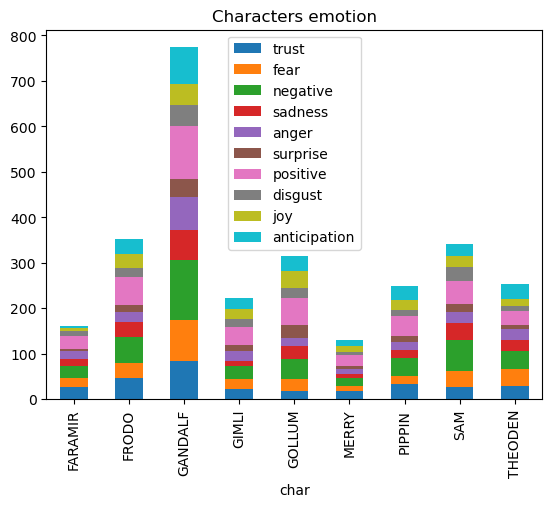

In [44]:

char_emot_filtered = char_emot[char_emot['char'].isin(imp_char)]

char_emot_filtered.plot(x='char', kind='bar', stacked=True,
        title='Characters emotion')
plt.show()

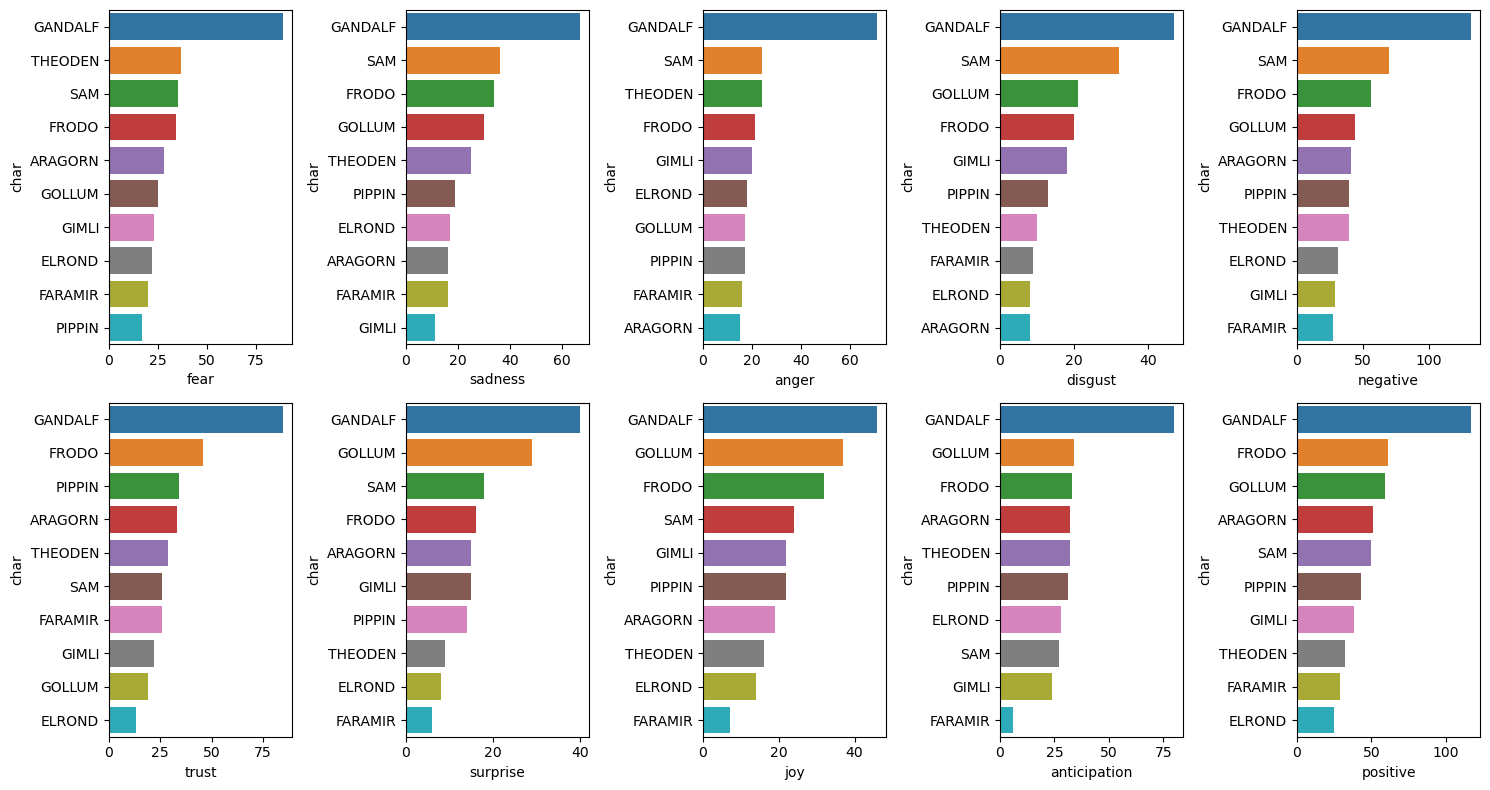

In [50]:
em_list = ['fear',  'sadness', 'anger', 'disgust', 'negative', 
           'trust', 'surprise',  'joy', 'anticipation', 'positive']

def char_emot_subplot(data, x):
    plt.figure(figsize = (15, 8))
    for i in range(1, len(x)+1):
        plt.subplot(2, 5, i)
        data = data.sort_values(by=x[i-1], ascending=False)[:10]
        sns.barplot(x=data[x[i-1]], y=data.char)
    plt.tight_layout()
    plt.show()

char_emot_subplot(char_emot, em_list)

### AVG TF-IDF Score for dialog

In [68]:
def tf(document: List[str], term: str) -> float:

    term_freq = FreqDist()
    for word in document:
        if word.lower() == term:
            term_freq[term] += 1
    
    termfreq = (term_freq[term])/len(document)
    return termfreq


def idf(documents: List[List[str]], term: str) -> float:

    doc_count = 0
    for doc in documents:
        if term in doc:
            doc_count +=1
    if doc_count == 0:
        return 0
    
    idf = np.log(len(documents)/(doc_count))
    return idf


def tf_idf(all_documents: List[List[str]], document: List[str], term: str) -> float:

    term_freq = tf(document, term)
    inverse_df = idf(all_documents, term)
    tf_idf = term_freq*inverse_df

    return tf_idf



dialog_avg_tfidf = []
for dialog in preprocessed:
    score = 0
    for term in dialog:
        p = tf_idf(lotr_data.dialog, dialog, term)
        score += p
    avg_tfidf = score/(len(dialog)+1)
    dialog_avg_tfidf.append(avg_tfidf)
    
lotr_data["avg_tf-idf"] = dialog_avg_tfidf


In [70]:
lotr_data

,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,...,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation,avg_tf-idf
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",12,62,1,2,0,3,10,0.250,...,0,0,0,0,0,0,0,0,0,0.291657
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",12,46,2,5,0,0,7,0.000,...,0,0,0,0,0,1,0,0,0,4.453624
2,DEAGOL,Arrghh!,1,8,0,1,0,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
3,SMEAGOL,Deagol!,1,9,0,0,0,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
4,SMEAGOL,Deagol!,1,9,0,0,0,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2385,PIPPIN,Merry!,1,7,0,0,0,1,1,0.625,...,0,0,0,0,0,0,0,0,0,0.000000
2386,ARAGORN,Merry!,1,7,0,0,0,1,1,0.625,...,0,0,0,0,0,0,0,0,0,0.000000
2387,MERRY,He's always followed me everywhere I went sinc...,40,211,19,5,1,2,35,0.000,...,0,0,0,0,0,0,0,0,0,0.392977
2388,ARAGORN,One thing I've learnt about Hobbits: They are ...,12,65,5,1,1,1,12,0.000,...,0,0,0,0,0,1,0,1,0,0.719619
